# *CS540 PROJECT : CS CHATBOT*

-**_by TEAM F_**
- **Pavithra Govardhanan**
- **Saptarshi Chatterjee**
- **Shree Harini Ravichandran**
- **Rusha Lawande**




### Importing Packages 

In [2]:
import numpy
import random
import json
import pickle
import nltk
import tensorflow as tf
from flask import Flask,render_template
import flask_restful as restful
from flask_restful import reqparse, abort, Api, Resource
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, TimeDistributed
from tensorflow. keras.utils import plot_model
from tensorflow.keras.models import Sequential
from nltk.stem.lancaster import LancasterStemmer

nltk.download('punkt')

C:\Users\pavig\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pavig\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pavig\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pavig\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

True

### Reading JSON File 

In [3]:
with open("covid_dataset.json",encoding="utf-8") as data:
        contents = json.load(data)

### Pre-Processing

In [4]:
try:
    # [IMP: If you changing the json input data, delete the pickle file and try running code again]

    # Try loading already pre-processed data from the pickle file.
    with open("cache.pickle", "rb") as f:
        vocabulary, labels, training, output = pickle.load(f)

except:

    # If no stored data in pickle file, pre-process the data, and store it now.
    vocabulary = []
    labels = []
    docs_x = []
    docs_y = []

    # Extract words from the patterns, extract labels (tags)

    for intent in data["intents"]:
        for pattern in intent["patterns"]:

            tokenized_words = nltk.word_tokenize(pattern) #toknising the data
            vocabulary.extend(tokenized_words)  #What is extending?
            docs_x.append(tokenized_words)
            docs_y.append(intent["tag"])

        if intent["tag"] not in labels:
            labels.append(intent["tag"])

    
    vocabulary = [word_stemmer.stem(w.lower()) for w in vocabulary if w != "?"] 
    vocabulary = sorted(list(set(vocabulary)))

    labels = sorted(labels)


    training = []
    output = []

    out_empty = [0 for _ in range(len(labels))]

    for x, doc in enumerate(docs_x):
        bag_of_words = []

        wrds = [word_stemmer.stem(w) for w in doc]

        for w in vocabulary:
            if w in wrds:
                bag_of_words.append(1)
            else:
                bag_of_words.append(0)

        output_row = out_empty[:]
        output_row[labels.index(docs_y[x])] = 1

        training.append(bag_of_words)
#         print(training)
        output.append(output_row)

  

    training = numpy.array(training)
    output = numpy.array(output)

    # Write the pre-processed data into the pickle file to use it subsequent time.
    with open("cache.pickle", "wb") as f:
        pickle.dump((vocabulary, labels, training, output), f)



In [5]:

len(vocabulary)

304

### Bag of Words 

In [6]:
def bag_of_words(user_query, vocabulary):
    bag = [0 for _ in range(len(vocabulary))]

    s_words = nltk.word_tokenize(user_query)
    s_words = [word_stemmer.stem(word.lower()) for word in s_words]

    for se in s_words:
        for i, w in enumerate(vocabulary):
            if se == w:
                bag[i] = 1

    return numpy.array(bag)


### Convolutional Neural Network(CNN) 

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
cnn_model = Sequential()
cnn_model.add(Embedding(304, 32, input_length=304))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size = 3))
# model.add(LSTM(100))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(172,activation='softmax'))
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 304, 32)           9728      
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 128)          20608     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                640050    
_________________________________________________________________
dense_1 (Dense)              (None, 172)               8772      
Total params: 679,158
Trainable params: 679,158
Non-trainable params: 0
__________________________________________________

In [9]:
cnn=cnn_model.fit(training, output, epochs=100,verbose = 2, batch_size=16)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
428/428 - 0s - loss: 0.0357 - acc: 0.9942
Epoch 2/100
428/428 - 0s - loss: 0.0353 - acc: 0.9942
Epoch 3/100
428/428 - 0s - loss: 0.0347 - acc: 0.9942
Epoch 4/100
428/428 - 0s - loss: 0.0333 - acc: 0.9942
Epoch 5/100
428/428 - 0s - loss: 0.0296 - acc: 0.9942
Epoch 6/100
428/428 - 0s - loss: 0.0243 - acc: 0.9944
Epoch 7/100
428/428 - 0s - loss: 0.0188 - acc: 0.9952
Epoch 8/100
428/428 - 0s - loss: 0.0149 - acc: 0.9960
Epoch 9/100
428/428 - 0s - loss: 0.0118 - acc: 0.9970
Epoch 10/100
428/428 - 0s - loss: 0.0082 - acc: 0.9976
Epoch 11/100
428/428 - 0s - loss: 0.0057 - acc: 0.9982
Epoch 12/100
428/428 - 0s - loss: 0.0049 - acc: 0.9986
Epoch 13/100
428/428 - 0s - loss: 0.0048 - acc: 0.9987
Epoch 14/100
428/428 - 0s - loss: 0.0030 - acc: 0.9992
Epoch 15/100
428/428 - 0s - loss: 0.0020 - acc: 0.9994
Epoch 16/100
428/428 - 0s - loss: 0.0013 - acc: 0.9995
Epoch 17/100
428/428 - 0s - loss: 0

In [10]:
cnn_model.save('model_covid_cnn.h5')
print("Model saved successfully...")

Model saved successfully...


### Accuracy (CNN) 

In [11]:


scores = cnn_model.evaluate(training, output, verbose=1)
print("Accuracy:", scores[1])

428/428 [==============================] - 0s 176us/sample - loss: 5.2302e-04 - acc: 0.9996
Accuracy: 0.9996469


### Graph results of CNN 

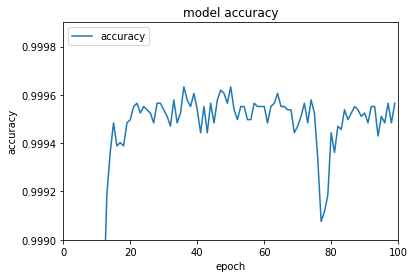

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cnn.history['acc'])
plt.title('model accuracy')
plt.ylim(0.9990,0.9999)
plt.xlim(0,100)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()

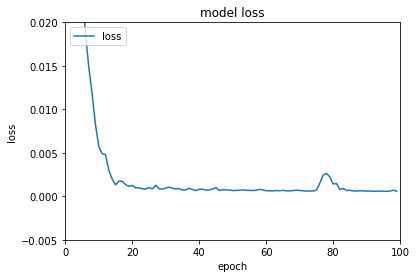

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cnn.history['loss'])
plt.title('model loss')
plt.ylim(-0.005,0.02)
plt.xlim(0,100)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

### Recurrent Neural Network (RNN)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM,SimpleRNN
rnn_model = Sequential()
rnn_model.add(Embedding(304, 32, input_length=304))
rnn_model.add(SimpleRNN(128, activation='relu', return_sequences=True))
rnn_model.add(Flatten())
rnn_model.add(Dense(50, activation='relu'))
rnn_model.add(Dense(172,activation='softmax'))
rnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


In [16]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 304, 32)           9728      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 304, 128)          20608     
_________________________________________________________________
flatten_1 (Flatten)          (None, 38912)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1945650   
_________________________________________________________________
dense_2 (Dense)              (None, 172)               8772      
Total params: 1,984,758
Trainable params: 1,984,758
Non-trainable params: 0
_________________________________________________________________


In [17]:
rnn=rnn_model.fit(training, output, epochs=100,verbose = 2, batch_size=16,validation_split=0.1)


Train on 385 samples, validate on 43 samples
Epoch 1/100
 - 2s - loss: 5.1387 - accuracy: 0.0104 - val_loss: 5.2224 - val_accuracy: 0.0000e+00
Epoch 2/100
 - 2s - loss: 4.9781 - accuracy: 0.0208 - val_loss: 5.6572 - val_accuracy: 0.0000e+00
Epoch 3/100
 - 2s - loss: 4.1964 - accuracy: 0.1818 - val_loss: 8.6300 - val_accuracy: 0.0465
Epoch 4/100
 - 2s - loss: 2.7957 - accuracy: 0.4364 - val_loss: 11.9850 - val_accuracy: 0.0465
Epoch 5/100
 - 2s - loss: 1.6446 - accuracy: 0.6000 - val_loss: 18.3188 - val_accuracy: 0.0465
Epoch 6/100
 - 2s - loss: 1.0217 - accuracy: 0.7299 - val_loss: 28.3346 - val_accuracy: 0.0465
Epoch 7/100
 - 2s - loss: 0.6790 - accuracy: 0.8338 - val_loss: 28.2194 - val_accuracy: 0.0465
Epoch 8/100
 - 2s - loss: 0.6016 - accuracy: 0.8831 - val_loss: 28.7234 - val_accuracy: 0.0465
Epoch 9/100
 - 2s - loss: 0.4252 - accuracy: 0.8935 - val_loss: 28.0300 - val_accuracy: 0.0465
Epoch 10/100
 - 2s - loss: 0.2140 - accuracy: 0.9403 - val_loss: 32.3394 - val_accuracy: 0.046

Epoch 84/100
 - 2s - loss: 0.0538 - accuracy: 0.9662 - val_loss: 29.6782 - val_accuracy: 0.0465
Epoch 85/100
 - 2s - loss: 0.0573 - accuracy: 0.9481 - val_loss: 29.1213 - val_accuracy: 0.0465
Epoch 86/100
 - 2s - loss: 0.0540 - accuracy: 0.9532 - val_loss: 29.1520 - val_accuracy: 0.0465
Epoch 87/100
 - 2s - loss: 0.0694 - accuracy: 0.9558 - val_loss: 26.6940 - val_accuracy: 0.0465
Epoch 88/100
 - 2s - loss: 0.0678 - accuracy: 0.9532 - val_loss: 26.9373 - val_accuracy: 0.0465
Epoch 89/100
 - 2s - loss: 0.0630 - accuracy: 0.9532 - val_loss: 25.7277 - val_accuracy: 0.0465
Epoch 90/100
 - 2s - loss: 0.0576 - accuracy: 0.9584 - val_loss: 27.3441 - val_accuracy: 0.0465
Epoch 91/100
 - 2s - loss: 0.0563 - accuracy: 0.9636 - val_loss: 28.8540 - val_accuracy: 0.0465
Epoch 92/100
 - 2s - loss: 0.0556 - accuracy: 0.9584 - val_loss: 28.3155 - val_accuracy: 0.0465
Epoch 93/100
 - 2s - loss: 0.0570 - accuracy: 0.9610 - val_loss: 28.8251 - val_accuracy: 0.0465
Epoch 94/100
 - 2s - loss: 0.0544 - accu

### Accuracy (RNN) 

In [18]:
rnn_model.save('model_covid_rnn.h5')
print("Model saved successfully...")

scores = rnn_model.evaluate(training, output, verbose=1)
print("Accuracy:", scores[1])

Model saved successfully...
428/428 [==============================] - 0s 771us/step
Accuracy: 0.8738317489624023


### Graph results of RNN 

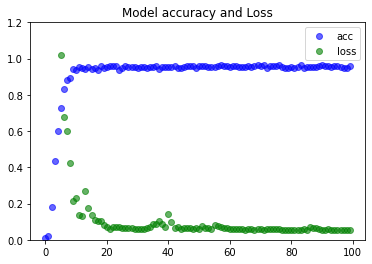

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

acc=rnn.history['accuracy']
loss=rnn.history['loss']


epochs=range(len(acc))

plt.plot(epochs,acc,'bo', alpha = 0.6, label='acc')
plt.ylim(0,1.2)
plt.plot(epochs, loss,'go',alpha=0.6, label='loss')
plt.title('Model accuracy and Loss')
plt.legend()